## Classification Speech and Silence Project

This dataset contains a list of audio(4 file) and a list of file .lab(4 file)

**Import library**
1. In project we using library:
   1. Numpy 
   2. soundfile : using read file .wav
   3. matplotlib.pyplot
   4. os
   5. scipy

In [124]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
import scipy

**Load Signal and Frequency rate**

In [125]:
def Load_signal(file_name) :
    signal, Fs = sf.read(file_name)
    return Fs, signal 

**Plot Signal**

In [126]:
def Plot_signal (Fs, signal ) :
    t_audio = np.linspace(0, len(signal) /Fs, num = len(signal))
    plt.figure(1)
    plt.title('Audio original')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.plot(t_audio, signal)
    plt.show()

**Divisor frame**
1. Divisor frame, we using frame length = 0.02 ms and frame shift = 0.01 
2. The function just used to Divisor frames and label those frames according to the timestamps from the .lab . file 

In [127]:
def Divisor_frame(Fs, signal, label):
    
    frame_length = round(Fs * 0.02)
    frame_shift = round(Fs * 0.01)

    Frames = []
    lb = []
    start = 0
    i=0
    while start + frame_length <= len(signal):
        Frames.append(signal[start:start+frame_length])
        if start/Fs >= label[i][1]: 
            i += 1
        if label[i][2] == "sil": 
            lb.append("sil")
        else :
            lb.append("spk")
            
        start += frame_shift
    
    return (np.asarray(Frames), np.asarray(lb))

**Calculator STE Per Frame**

In [128]:
def STE_calc_frame(Frames):
    STEs = []                                      # list of short-time energies
    for k in range(len(Frames)):            
        STE = sum( abs(x) ** 2 for x in Frames[k]) 
        STEs.append(STE)  
    return np.array(STEs/max(STEs))

**Calculator threshold**
1. Find threshold using histogram
   1. Tìm danh sách các điểm là điểm thung lũng trong histogram 
   2. tìm giá trị min của những điểm thung lũng là giá trị threshold cần tìm 

In [129]:
def Find_threshold (STEs):
    # Find peaks in histogram
    counts, bin_edges = np.histogram(STEs, bins= 100)
    # Set threshold to the valley between the peaks
    valleys, _ = scipy.signal.find_peaks(-counts, height= -np.inf)
    valley_values = bin_edges[valleys]
    threshold = min(valley_values)
    
    return threshold

In [130]:
def Get_mean_std(STEs):
    mean_energy = np.mean(STEs)
    std_energy = np.std(STEs)
    return mean_energy, std_energy

**Load Data**
1. Gán nhãn cho các frame từ dữ liệu timestamp của file .lab
2. Chia Frame có độ dài là 0.02 và độ dời là 0.01 của các tín hiệu trong tập dữ liệu

In [131]:
def Load_data(dir):
    X_train = []
    Y_label = []
    data = []
    label = []
    a = []
    #BASE_DIR = os.path.abspath(os.getcwd())
    #data_dir = os.path.join(BASE_DIR,'DataSet')
    data_dir = "E:/"
    for root, dirs, files in os.walk(data_dir):
        if root.endswith(dir) :
            for file in files:
                i = 0
                if file.endswith("txt"):
                    path = os.path.join(root, file)
                    a = np.genfromtxt(path, dtype=(float, float, 'U10'))
                    label.append(a)  
                if file.endswith("wav") :
                    path = os.path.join(root, file)
                    Fs, signal = Load_signal(path)
                    data.append([Fs, signal])
    for i in range(4):
        frame, lb = Divisor_frame(data[i][0],data[i][1],label[i])
        X_train.append(frame)
        Y_label.append(lb) 

    return X_train, Y_label

**Labeling**
1. Nhận dạng các frame là tiếng nói hay khoảng lặng và gán nhãn chúng:
   1. Nếu năng lượng lớn hơn ngưỡng thì đó là tiếng nói --> nhãn 'spk'
   2. Nếu năng lượng nhỏ hơn ngưỡng thì đó là khoảng lặng --> nhãn 'sil'

In [132]:
def Labeling(STEs, threshold):
    labels = []
    for e in STEs:
        if e >= threshold:
            labels.append('spk')
        else:
            labels.append('sil')
    return np.asarray(labels)

**Recoginition fragment Speech and Silence**
1. Load tín hiệu và chia frame và gãn nhãn trước từ timestamp file .lab 
2. Chia tín hiệu cần được nhận dạng thành các frame 
3. Tính năng lượng của từng frame vừa được chia của tín hiệu vào
4. Gán nhãn chúng bằng cách so sánh với ngưỡng
5. So sánh độ chính xác của các nhãn vừa được gán với các nhãn được gắn từ timestamp file .lab

In [141]:
X_train, Y_label = Load_data("TinHieuHuanLuyen")
STEs = []
label_end = []
for i in range(4):
    STEs.append(STE_calc_frame(X_train[i]))
for i in range(4):

    lb = Labeling(STEs[i], Find_threshold(STEs[i]))
    label_end.append(lb)
    #Plot_signal(Fs,signal)
    cost = []
    x = 0
    y = 0
for i in range(4):
    A = Y_label[i] == label_end[i]
    x += np.sum(A)
    y+= np.size(Y_label[i])
print("Cost Function = ", y-x)
print(x/y)

Cost Function =  242
1308
0.8149847094801224


Nhận xét: 
1. Với giá trị X(threshold) của mỗi tín hiệu vừa tìm được ta bắt đầu nhận dạng và so khớp với nhãn đã được gắn ban đầu.
2. Với kết quả so khớp ta thấy độ chính xác 81.49% là một kết quả không tốt lắm. 
3. Điều này khiến ta phải tìm giá trị X* sao cho tỉ lệ nhận dạng đúng cao nhất( agrmin costfunction).

Tìm giá trị agrmin X* 
1. Sau khi tính giá trị STE của mỗi tín hiệu ta sẽ lọc trung vị với mỗi tín hiệu
2. Với mỗi giá trị STE đã được lọc trung vị ta tính được 1 threshold. -> vậy sau khi thực hiện 1 và 2 ta có 2 array 4 phần tử bao gồm STEs và thresholds
3. Tìm giá trị X*
   1. Tính giá trị mean(thresholds) và std(thresholds) từ bước 2.
   2. Gán giá trị X* được tăng dần từ giá trị mean - 2.std đến mean + 2.std 
   3. Với mỗi giá trị X* ta điều đi kiểm tra xem độ chính xác của nhãn ta vừa gán và nhãn ta đã có từ file .lab 
4. Nhận xét rồi lấy giá trị làm cho độ chính xác cao nhất (argmin Costfunction)
5. Rút ra đó là ngưỡng tối ưu (X*) mà ta cần tìm để nhận dạng. 

In [134]:
def Calc_stes_files(X_train):
    STEs = []
    thresholds = []
    for frame in  X_train: 
        ste = STE_calc_frame(frame)
        # smooth Ste 
        ste = scipy.signal.savgol_filter(ste, 7, 3 )
        STEs.append(ste)
        threshold = Find_threshold(ste)
        thresholds.append(threshold)
    return STEs, thresholds

In [135]:
def find_thresholds(thresholds, STEs, Y_label):

    percenty_result = []

    mean_threshold = np.mean(thresholds)
    std_threshold = np.std(thresholds)

    start_threshold = mean_threshold - 2*std_threshold
    end_threshold = mean_threshold + 2*std_threshold

    threshold_range = np.linspace(start_threshold, end_threshold , num = 100 )
        
    for threshold in threshold_range:
        x = 0
        y = 0
        for j in range(4):        
            label = Labeling(STEs[j],threshold)

            A = Y_label[j] == label
            x += np.sum(A)
            y += np.size(Y_label[j])
        percenty_result.append([threshold, x/y])
    return np.asarray(percenty_result)

100


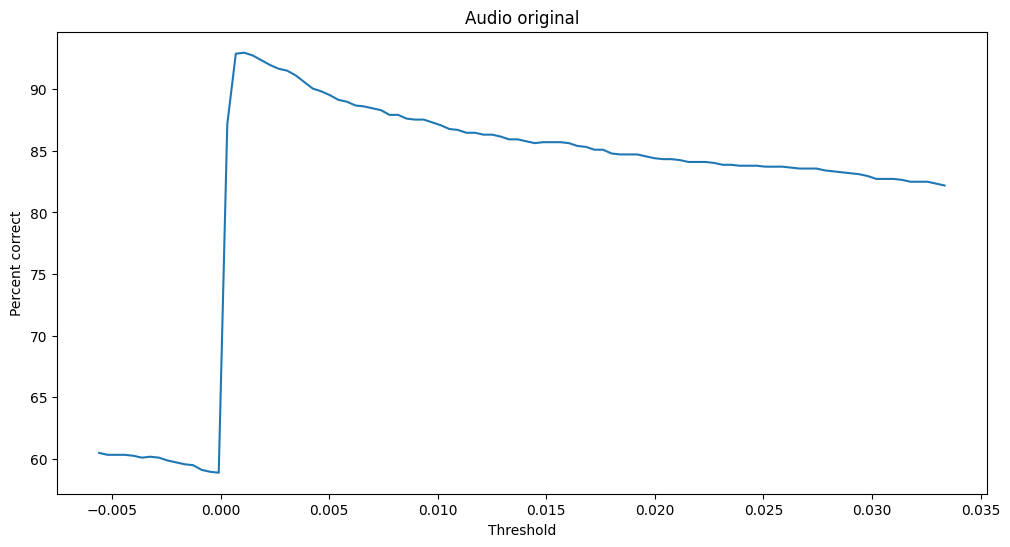

[[-0.0032319   0.60168196]
 [ 0.0010944   0.92966361]
 [ 0.01525319  0.85703364]]


In [142]:
X_train, Y_label = Load_data("TinHieuHuanLuyen")
STEs, thresholds = Calc_stes_files(X_train)
result_thresholds = find_thresholds(thresholds, STEs, Y_label)
plt.figure(figsize=(12, 6))
plt.title('Audio original')
plt.xlabel('Threshold')
plt.ylabel('Percent correct')
plt.plot( result_thresholds[:,0], result_thresholds[:,1]*100)
plt.show()

valleys, _ = scipy.signal.find_peaks(result_thresholds[:,1])
valley_values = result_thresholds[valleys]
print(valley_values)


Thực hiện việc X* trên ta thấy giá trị X* = 0.001094 cho kết quả độ chính xác cao nhất
--> nên ta rút ra giá trị chính xác của việc nhận dạng rơi vào khoảng 92.966 %

1. Nhận xét độ chính xác của nhận dạng:
   1. Độ chính xacs của nhận dạng rơi vào khoảng tầm 92.966%
   2. Số khung bị sai lệch giữa tiếng nói và khoảng lặng rơi vào khoảng 78 khung/ 1300 khung (7%) 

**Plot Decision boundary**

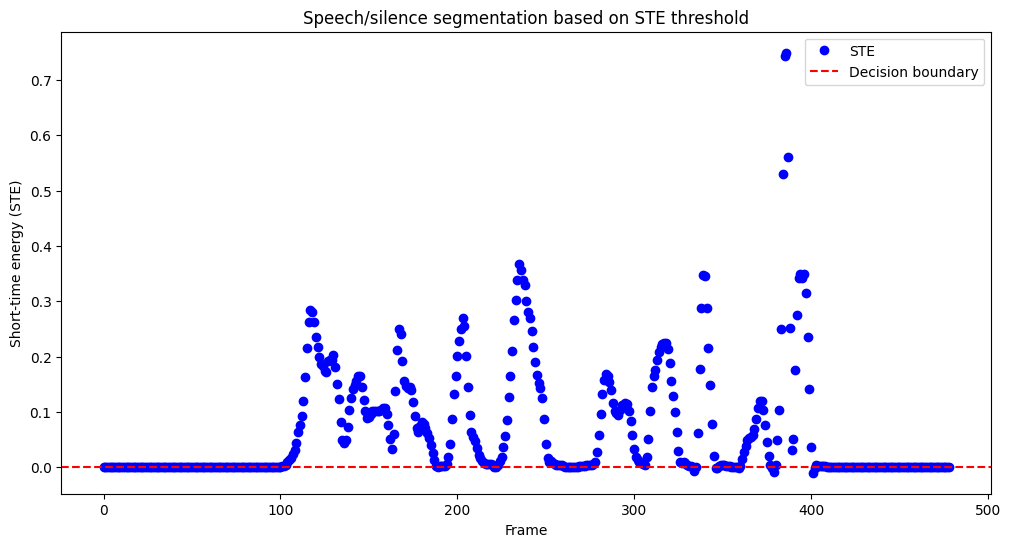

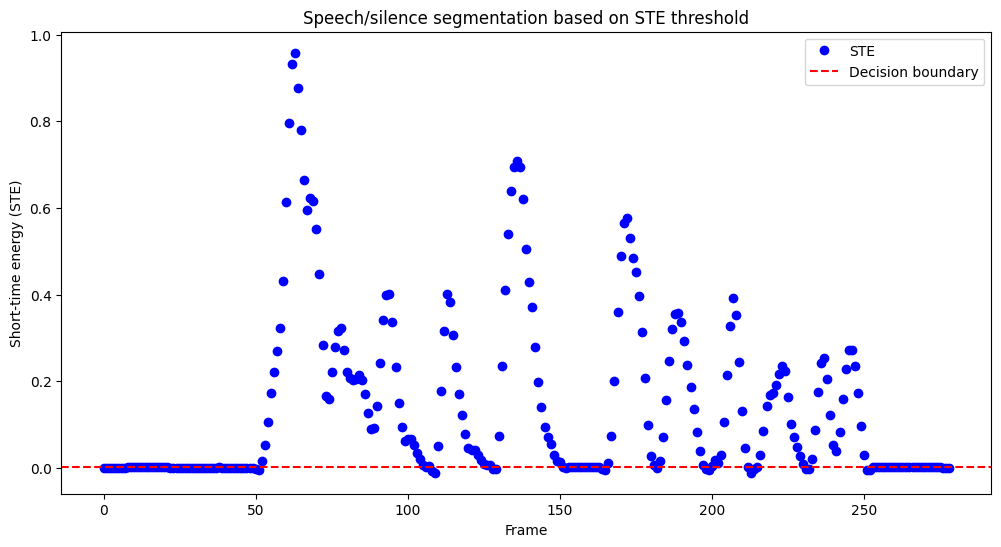

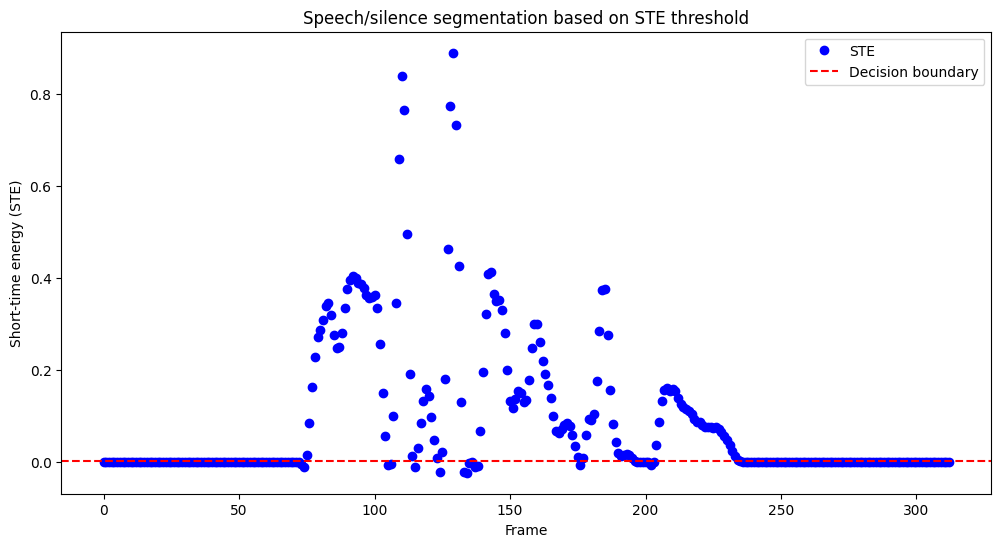

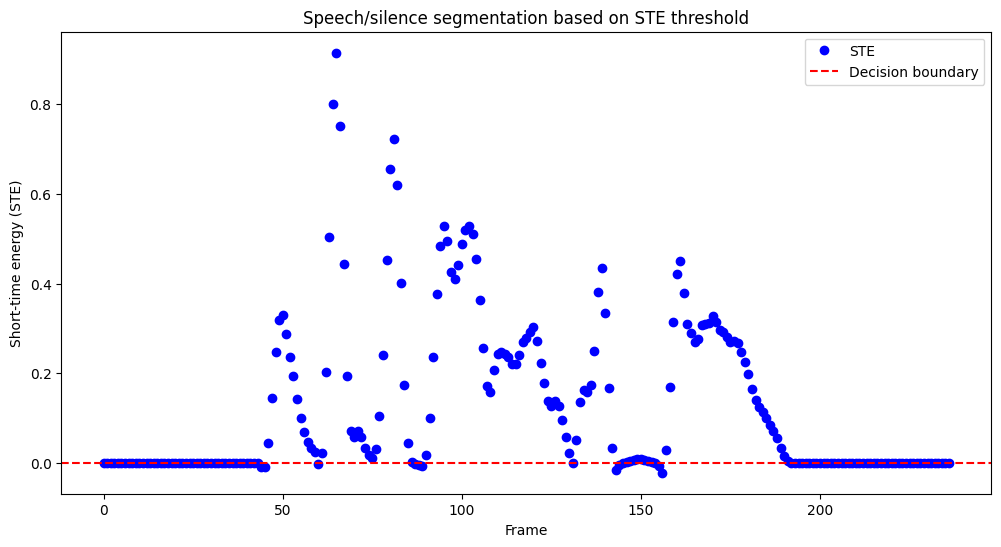

In [137]:
for STE in STEs:

    # Plot decision boundary
    plt.figure(figsize=(12, 6))
    plt.plot(STE, "bo", label="STE")
    plt.axhline(y= 0.001094 , color="r", linestyle="--", label="Decision boundary")
    plt.xlabel("Frame")
    plt.ylabel("Short-time energy (STE)")
    plt.title("Speech/silence segmentation based on STE threshold")
    plt.legend()
    #plt.bar(STE)
    plt.show()

1. Nhận xét biên quyết định:
    1. Những điểm(frame) nằm phía trên đường biên là những điểm(frame) có năng lượng lớn và là khung tiếng nói  
    2. Những điểm(frame) nằm phía dưới đường biên là những điểm(frame) có năng lượng lớn và là khung khoảng lặng

**DANH GIA TREN TAP KIEM THU**

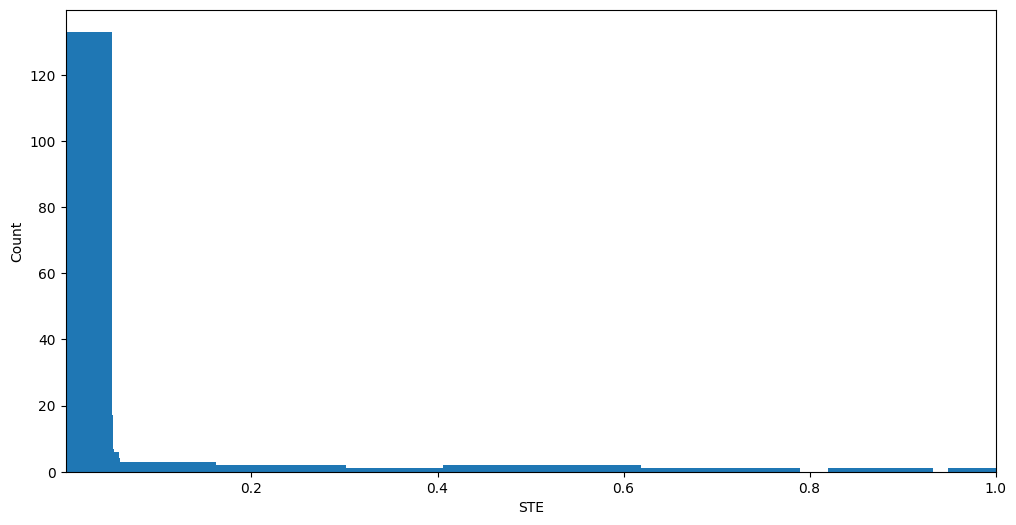

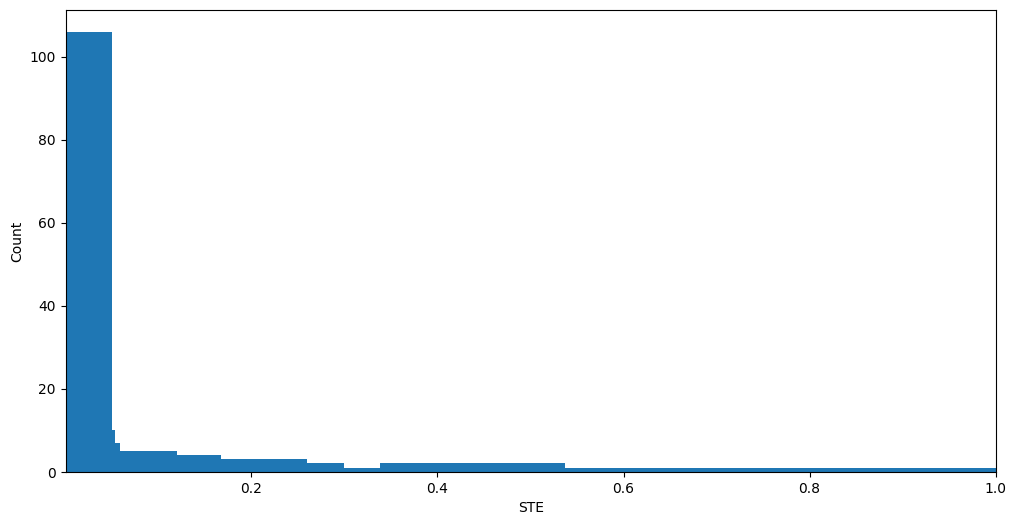

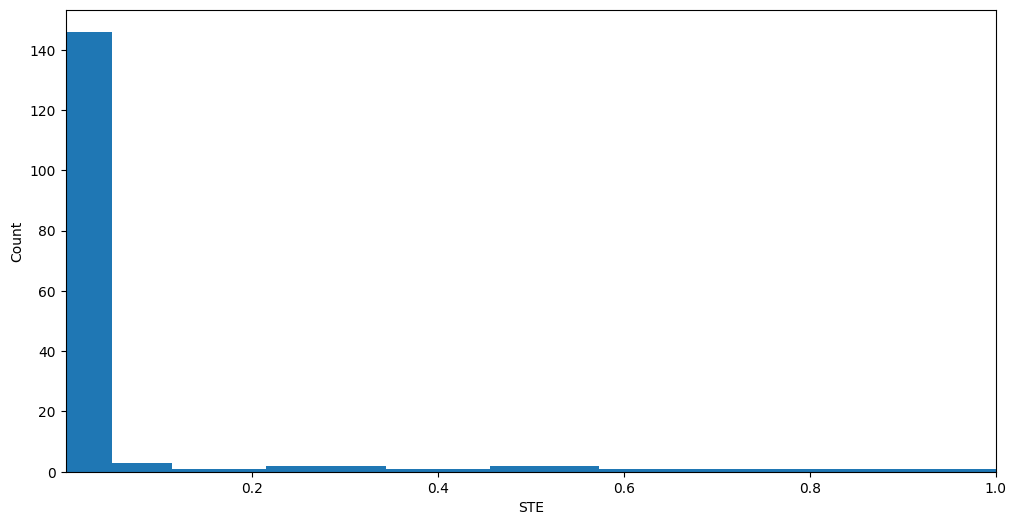

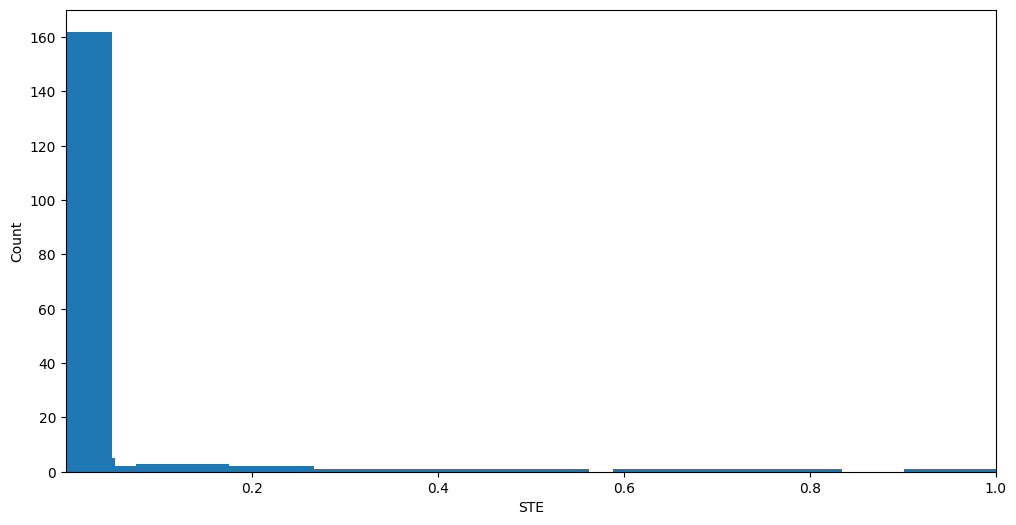

Cost Function =  82
0.9366795366795366


In [143]:
X_train, Y_label = Load_data("TinHieuKiemThu")
STEs = []
label_end = []
for i in range(4):
    STEs.append(STE_calc_frame(X_train[i]))
for i in range(4):
    # Calculate histogram of STE
    hist, bin_edges = np.histogram(STEs[i], bins=1000)

    # Visualize the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(bin_edges[:-1], hist, width=0.1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.xlabel('STE')
    plt.ylabel('Count')
    plt.show()

    lb = Labeling(STEs[i], 0.001094)
    label_end.append(lb)
    #Plot_signal(Fs,signal)
    cost = []
    x = 0
    y = 0
for i in range(4):
    A = Y_label[i] == label_end[i]
    x += np.sum(A)
    y+= np.size(Y_label[i])
print("Cost Function = ", y-x)
print(x/y)

1. Nhận xét hist togram:
    1. Histogram có 1 phân bố đó là phân bố gần gần với giá trị 0 và mod của phân bố đó là giá 0 -> 0.01 
    2. Sô Frame có giá trị gần giá trị 0 chiếm khoảng 40%
2. Nhận xét độ chính xác của nhận dạng:
   1. Độ chính xacs của nhận dạng rơi vào khoảng tầm 93.668%
   2. Số khung bị sai lệch giữa tiếng nói và khoảng lặng rơi vào khoảng 80 khung/ 1300 khung (6%) 

Nhận xét toàn bài: 
1. Thuật toán nhận dạng số khung tiếng nói và khoảng lặng đạt độ chính xác khá cao.
2. Thuật toán nhận dạng còn nhầm lẫn lẫn các khung giữa tiếng nói và khoảng lặng còn khoảng 6%
   1. Nguyên nhân vì chưa lọc khoảng lặng ảo 
   2. Mô hình tính threshold chưa tối ưu.